In [ ]:
pip install auto_diff

In [ ]:
# The lazy man's imports are here.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as stats
from scipy.special import eval_legendre
import random
from tqdm import tqdm
import auto_diff

import cvxpy as cp
import pandas as pd

location = '/content/drive/MyDrive/ECE50024'

# **Dataset Setup - MNIST**
Classifying threes and fives - 1,000 per dataset

In [ ]:
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# How much noise do you want to throw in?
num_ones = 0
# Finishes around 33%
three = np.ravel(np.array(np.zeros(train_images[0].shape)))
five = np.ravel(np.array(np.zeros(train_images[0].shape)))
ones = np.ravel(np.array(np.zeros(train_images[0].shape)))
first_three = False
first_five = False
first_noise = False

for i in tqdm(range(len(train_images))):
  if int(train_labels[i]) == 4 and (len(three) < 1601  or (not first_three)):
    three = np.vstack((three, np.ravel(train_images[i])))
    first_three = True
  if int(train_labels[i]) == 9 and (len(five) < 1601  or (not first_five)):
    five = np.vstack((five, np.ravel(train_images[i])))
    first_five = True
  if int(train_labels[i]) == 1 and (len(ones) < num_ones+1 or (not first_noise)):
    ones = np.vstack((ones, np.ravel(train_images[i])))
    first_noise = True

three = three[1:]/100
five = five[1:]/100
noise = ones[1:]/100

100%|██████████| 60000/60000 [00:04<00:00, 13795.02it/s]


In [ ]:
# Only 1500 threes TOTAL
num_train_threes = 990
num_test_threes = 300
num_valid_threes = 270

# Only 1500 fives TOTAL
num_train_fives = 10
num_test_fives = 300
num_valid_fives = 30

train_three = three[:num_train_threes]
valid_three = three[num_train_threes:num_train_threes+num_valid_threes]
test_three = three[num_train_threes+num_valid_threes:num_train_threes+num_valid_threes+num_test_threes]

train_five = five[:num_train_fives]
valid_five = five[num_train_fives:num_train_fives+num_valid_fives]
test_five = five[num_train_fives+num_valid_fives:num_train_fives+num_valid_fives+num_test_fives]

# 2,000 items in train...
if num_ones == 0:
  train_X = np.vstack((train_three, train_five))
  train_Y = np.vstack((np.zeros((num_train_threes, 1)), np.ones((num_train_fives, 1))))
else:
  train_X = np.vstack((train_three, train_five, noise))
  train_Y = np.vstack((np.zeros((num_train_threes, 1)), np.ones((num_train_fives, 1)), np.ones((num_ones, 1))*0.5))

# 600 items in validation...
valid_X = np.vstack((valid_three, valid_five))
valid_Y = np.vstack((np.zeros((num_valid_threes, 1)), np.ones((num_valid_fives, 1))))

# 600 items in test...
test_X = np.vstack((test_three, test_five))
test_Y = np.vstack((np.zeros((num_test_threes, 1)), np.ones((num_test_fives, 1))))

In [ ]:
len(train_X), len(train_Y)

(1000, 1000)

# **Implementation**

#### Gradient Descent Functions

In [ ]:
def direction_2norm(X, y, theta):
  '''
  Finds the gradient direction vector (aka just the gradient) for linear regression given the array of values, current iteration theta, and the expected result vector.

  Inputs:
      X     : np.Array (matrix) : Typically an array of inputs in ML
      y     : np.Array (vector) : Typically an array of expected outputs in ML
      theta : np.Array (vector) : The current step we're on in gradient descent. Probably not perfect.

  Outputs:
      d     : np.Array (vector) : The gradient descent vector, which is gradient(E(theta)), where E is just the MSE formula.

  '''

  return 2*np.matmul(np.transpose(X), np.matmul(X, theta)-y)

def sigmoid(x, theta):
  '''
  Calculates the sigmoid function given x, theta
  '''
  e_tx = np.exp(np.matmul(x, theta)).item()

  return e_tx/(1+e_tx)

def array_sigmoid(x, theta):
  '''
  Calculates the sigmoid function given X, theta, as a vector.
  '''
  e_tx = np.exp(np.matmul(x, theta))

  return np.divide(e_tx, 1+e_tx)

def gradient_cross(X, y, theta, w = None, lamb = 0.001):
  '''
  Finds the gradient direction vector (aka just the gradient) for cross entropy loss given the array of values, current iteration theta, and the expected result vector.

  Inputs:
      X     : np.Array (matrix) : Typically an array of inputs in ML
      y     : np.Array (vector) : Typically an array of expected outputs in ML
      theta : np.Array (vector) : The current step we're on in gradient descent. Probably not perfect.
      w     : np.Array (vector) : Weights to be used. If None, will build its own weights vector.
      lambda: float    (scalar) : The lambda being used here for regularization (may not converge otherwise)

  Outputs:
      grad  : np.Array (vector) : The gradient descent vector, which is gradient(E(theta)), where E is just the cross entropy loss formula.

  '''
  if np.array(w).any() == None:
    weights = np.ones(y.shape)*1.0/len(y)
  else:
    weights = w

  grad = np.zeros(theta.shape)
  for i in range(len(y)):
    temp = np.reshape(y[i]*np.transpose(X[i]) - sigmoid(X[i], theta)*np.transpose(X[i]), theta.shape)
    grad = grad - weights[i]*temp

  return grad + 2*lamb*np.matmul(np.transpose(theta), theta).item()

def fastgradient_cross(X, y, theta, w = None, lamb = 0.001):
  '''
  Finds the gradient for cross entropy loss; just faster.

  See gradient_cross() for docstring.
  '''
  if np.array(w).any() == None:
    weights = np.ones(y.shape)*1.0/len(y)
  else:
    weights = w

  term2 = np.matmul(np.transpose(X), np.multiply(weights, array_sigmoid(X, theta)))
  term1 = -np.matmul(np.transpose(X), np.multiply(weights, y))
  term3 = 2*lamb*theta

  return term1+term2+term3

def loss_ce(X, y, theta, w = None, lamb = 0.001):
  '''
  Finds cross entropy loss. Used primarily as a helper function for reweight step.

  Inputs:
      X     : np.Array (matrix) : Typically an array of inputs in ML
      y     : np.Array (vector) : Typically an array of expected outputs in ML
      theta : np.Array (vector) : The current step we're on in gradient descent. Probably not perfect.
      w     : np.Array (vector) : Weights to be used. If None, will build its own weights vector.
      lambda: float    (scalar) : The lambda being used here for regularization (may not converge otherwise)

  Outputs:
      loss  : float    (scalar) : Cross Entropy Loss

  '''
  if np.array(w).any() == None:
    weights = np.ones(y.shape)*1.0/len(y)
  else:
    weights = w

  loss = 0
  for i in range(len(y)):
    temp = np.reshape(y[i]*np.log(sigmoid(x[i]))+(1-y[i])*np.log(1-sigmoid(x[i])), theta.shape)
    loss = loss - weights[i]*temp

  return loss + 2*lamb*np.matmul(np.transpose(theta), theta).item()

## Batching For Gradient Descent

In [ ]:
def draw(a, b, n):
  '''
  Given range of numbers (a, b), draw n random numbers and return as a list.
  '''
  if (b-a) < n:
    return "Error"
  deck = list(range(a, b))
  random.shuffle(deck)
  return deck[:n]

def sgdBatch(X, Y, w, n):
  '''
  Given:
    X : Array of ALL training input data
    Y : Array of ALL training output data
    w : Vector of ALL training weights
    n : SGD batch size

  Produces a tuple:
    x_sgd : Array of batched training input data
    y_sgd : Array of batched training output data
    w_sgd : Array of batched training weights
    index : List of locations the weights came from

  This can also work for the validation batching. Simply perform these replacements:
    X -> Validation X
    Y -> Validation Y
    n -> Validation batch size m
  '''
  N = len(X)
  terms = draw(0, N, n)
  x_sgd = np.zeros((1,len(np.transpose(X))))
  y_sgd = np.zeros((1,len(np.transpose(Y))))
  w_sgd = np.zeros((1,len(np.transpose(w))))

  for i in terms:
    x_sgd = np.vstack((x_sgd, X[i]))
    y_sgd = np.vstack((y_sgd, Y[i]))
    w_sgd = np.vstack((w_sgd, w[i]))

  return (x_sgd[1:], y_sgd[1:], w_sgd[1:], terms)

## Actual Solution

In [28]:
n = 100 # SGD batch size
m = 40 # Validation batch size
iter = 4000 # num iterations

alpha = 0.005
eta = 0.005

# Build the weights vector and guess all weights are 1/n.
N = len(train_X)
M = len(valid_X)
w = np.ones((N,1))*1.0/n # tall vector, N x 1

100%|██████████| 4000/4000 [00:40<00:00, 97.82it/s] 


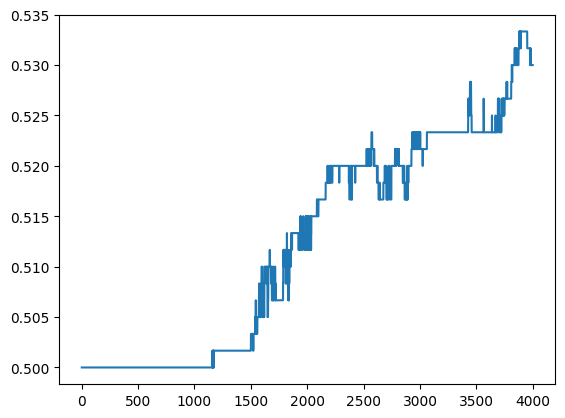

In [29]:
# Standard SGD
theta_sgd = np.zeros((len(train_X[0]), 1))
sgdAcc = []

for i in tqdm(range(iter)):

  # Training a theta
  x, y, e, idx = sgdBatch(train_X, train_Y, w, n)

  d = fastgradient_cross(x, y, theta_sgd)
  #alpha = alpha2norm(d, x, theta_sgd)

  # Calculating accuracy
  check = np.zeros(test_Y.shape)
  for i in range(len(check)):
    check[i] = sigmoid(test_X[i], theta_sgd)

  sgdAcc.append((np.round(check) == test_Y).sum()/len(test_Y))

  # Finding next theta
  theta_sgd = theta_sgd - alpha*d

check = np.zeros(test_Y.shape)
for i in range(len(check)):
  check[i] = sigmoid(test_X[i], theta_sgd)
sgdAcc.append((np.round(check) == test_Y).sum()/len(test_Y))
plt.plot(sgdAcc)

100%|██████████| 4000/4000 [31:20<00:00,  2.13it/s]


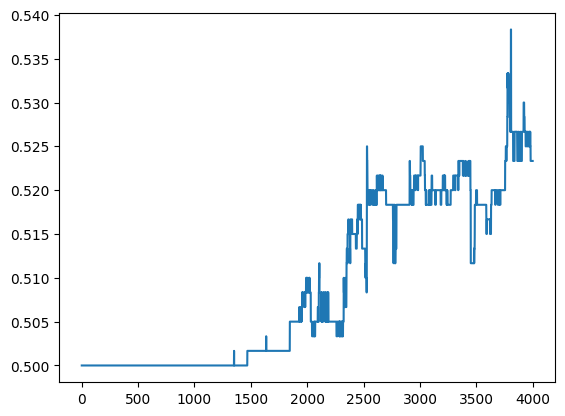

In [30]:
# SGD with weights - might be broken?

theta_exp = np.zeros((len(train_X[0]), 1))
expAcc = []

for i in tqdm(range(iter)):

  # Training a theta
  x, y, e, idx = sgdBatch(train_X, train_Y, w, n)

  d = fastgradient_cross(x, y, theta_exp, e)

  # Calculating accuracy
  check = np.zeros(test_Y.shape)
  for i in range(len(check)):
    check[i] = sigmoid(test_X[i], theta_exp)

  expAcc.append((np.round(check) == test_Y).sum()/len(test_Y))

  # Finding next theta
  theta_next = theta_exp - alpha*d

  # Get validation batches
  a, b, _, _ = sgdBatch(valid_X, valid_Y, w, m)

  # Find the next weights
  u = np.zeros(w.shape)
  for i in range(n):
    gradZone = 0
    for j in range(m):
      grad_comp = np.ravel(fastgradient_cross(a, b, theta_next))
      deriv_comp = -np.ravel(y[i]*np.transpose(x[i]) - sigmoid(x[i], theta_exp)*np.transpose(x[i]))
      gradZone = gradZone + np.dot(grad_comp, deriv_comp)

    u[i] = -eta*gradZone/m

  # Rectify for non-negative weights
  for j in range(len(u)):
    if u[j] < 0:
      u[j] = 0

  # Normalize weights for training batch
  u_sum = np.sum(u)
  for j in range(len(idx)):
    if u_sum > 0:
      w_loc = idx[j]
      w[idx] = u[j]/u_sum

  # Update theta
  theta_exp = theta_next

check = np.zeros(test_Y.shape)
for i in range(len(check)):
  check[i] = sigmoid(test_X[i], theta_exp)

expAcc.append((np.round(check) == test_Y).sum()/len(test_Y))
plt.plot(expAcc)

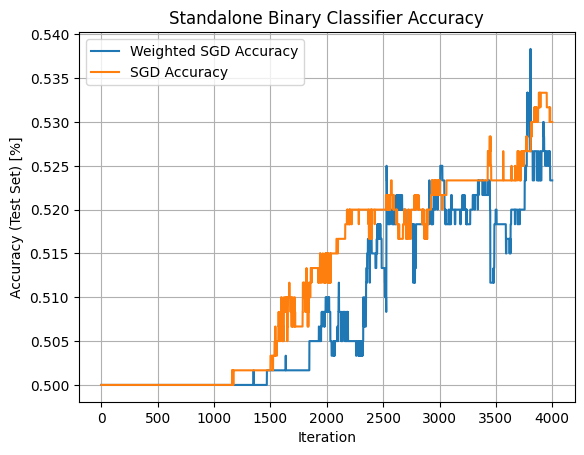

In [32]:
ax = plt.subplot(111)
plt.title("Standalone Binary Classifier Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (Test Set) [%]")
plt.plot(expAcc, label = "Weighted SGD Accuracy")
plt.plot(sgdAcc, label = "SGD Accuracy")
ax.grid()
#plt.plot(linregAcc, label = "Linear Regression Accuracy", color = "black")
plt.legend()